# **RW-atmos** 
*Analytical computation of Rayleigh-wave induced acoustic waves*

---


User-defined options:

1.   Fix physical domain boundaries
2.   Choose a source mechanism
3.   Set atmospheric parameters
4.   Choose display characteristics

Additionally, to set the seismic model, upload a file called "Ridgecrest_seismic.txt" in folder 'RW_atmos' with format:

`depth (m) rho (kg/m^3) vp (m/s) vs (m/s) Qs Qp`

And then run cell that shows **#2** 

To set the atmosphere model, upload a file called "atmospheric_model.dat" in folder 'RW_atmos' with format:

`z (m) rho (kg/m^3) cpa (m/s) p (Pa) g (m/s^2) kappa (Pa.s) mu (Pa.s) bulk (Pa.s) wx (m/s) wy (m/s) cp (J/K.kg) cv (J/K.kg) gamma`

And then run cell that shows **#4** 

To run the code: Got to Runtime -> Run all (ctrl + F9)


---


Dispersion equations in the atmosphere can be found in: *Godin, O. A. (2014). Dissipation of acoustic-gravity waves: An asymptotic approach. The Journal of the Acoustical Society of America, 136(6), EL411-EL417.*

Seismic Green's functions can be found in: *Aki, K., & Richards, P. G. (2002). Quantitative seismology.*

In [1]:
import os
import RW_atmos, RW_dispersion, velocity_models
import mechanisms as mod_mechanisms
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
%matplotlib inline

**Define the x / z boundaries of the physical domain as well as the frequency range**


*   Note that you will end up with a lot of aliasing if your model's dimensions are too small.
*   Take the number of frequencies as a power of 2
*   A large domain in options_source will lead to a very-large computational time

In [2]:
## Sample path name of the directory created to store data and figures
name_sample               = './RIDGECREST_XXX/'

## RW-atmos integration options
options = {}
options['dimension']         = 3 # atmospheric dimension
options['dimension_seismic'] = 3 # seismic dimension
options['ATTENUATION']    = True # using Graves, Broadband ground-motion simulation using a hybrid approach, 2014
options['COMPUTE_MAPS']   = False # Compute and plot x,y,z wavefield
options['nb_freq']        = 2**9
options['nb_kxy']         = 2**7
options['coef_low_freq']  = 0.001 # minimum frequency (Hz)
options['coef_high_freq'] = 5. # maximum frequency (Hz)
options['nb_layers']      = 100 # Number of seismic layers for discretization
options['zmax']           = 60000. # maximum depth (m)
options['nb_modes']       = [0, 50] # min, max number of modes
options['t_chosen']       = [40., 90.] # time (s) to display wavefield
options['models'] = {}
options['models']['specfem'] = './Ridgecrest_seismic.txt'
options['type_model']        = 'specfem' # specfem or specfem2d

## Source parameters
options_source = {}
options_source['stf-data'] = [] # file where stf is located
options_source['stf']      = 'gaussian' # gaussian or erf
options_source['f0']       = 5. # dominant freuqency (Hz)
options_source['lat_min'] = 35. 
options_source['lat_max'] = 36.
options_source['lon_min'] = -118.
options_source['lon_max'] = -117.

## Load sources from Earthquake catalog or build custom source
options_source['DIRECTORY_MECHANISMS'] = []
options_source['sources'] = []
source_characteristics = { # example of custom source
    'id': 0,
    'time': UTCDateTime(2019, 8, 9, 0, 9, 57),
    'mag': 2.98,
    'lat': 35.895,
    'lon': -117.679,
    'depth': 4.1, #km
    'strike': 159,
    'dip': 89,
    'rake': -156,
}
options_source['sources'].append( source_characteristics )
list_of_events = [0] # list of event to compute, leave empty if you want all    
options_source['add_SAC'] = False # Wheter or not add real station locations downloaded from IRIS within the domain
                                  # boundaries defined in options_source['lat_min'], options_source['lat_max'], ...

## Stations
options_IRIS = {}
options_IRIS['network'] = 'CI,NN,GS,SN,PB,ZY'
options_IRIS['channel'] = 'HHZ,HNZ,DPZ,BNZ,BHZ,ENZ,EHZ'
options_IRIS['stations'] = {}
x, y, z, comp, name, id = 100., 1000., 0., 'HHZ', 'test', 0
options_IRIS['stations'][id] = mod_mechanisms.create_one_station(x, y, z, comp, name, id)

## Load balloon data
options_balloon = {}

**You can plot the requested source mechanisms**

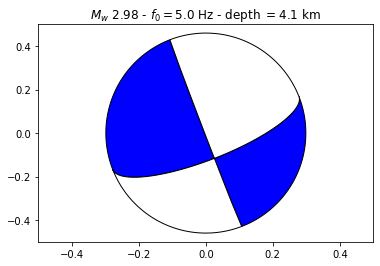

In [3]:
from pyrocko import moment_tensor as mtm
from obspy.imaging.beachball import beach
## Plot custom sources
for source in options_source['sources']:
    
    mw = source['mag']
    m0 = mtm.magnitude_to_moment(mw)  # convert the mag to moment
    strike, dip, rake = source['strike'], source['dip'], source['rake']
    mt = mtm.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=m0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    aa = (mt.m6_up_south_east()*m0).tolist()
    bball = beach(aa, xy=(0., 0.), width=200, linewidth=1, axes=ax)
    bball.set_zorder(100)
    ax.add_collection(bball)

    plt.title('$M_w$ ' + str(round(mw, 2)) + ' - $f_0 = ' +str(round(options_source['f0'],3))+ '$ Hz'+ ' - depth $ = ' +str(round(source['depth'],3))+ '$ km')
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])

**Construct source mechanisms and stations for RW atmos**

In [4]:
## ugly hack: copy options from one dict to another & initialize other options only relevant to Ridgecrest
options_source['coef_high_freq'] = options['coef_high_freq']
options_source['nb_kxy']   = options['nb_kxy']
options_source['t_chosen'] = options['t_chosen']
options_source['activate_LA'] = False # Only relevant for Ridgecrest study
options_source['rotation'] = False 
options['USE_SPAWN_MPI'] = False
options['force_dimension'] = False # Only when add_specfem_simu = True
options['force_f0_source'] = False
mechanism, station, domain = {}, {}, {}
keys_mechanism = ['EVID', 'stf', 'stf-data', 'zsource', 'f0', 'M0', 'M', 'phi', 'station_tab', 'mt']

## Load mechanisms/stations data
mechanisms_data = mod_mechanisms.load_source_mechanism_IRIS(options_source, options_IRIS, dimension=options['dimension'], 
                                                                    add_SAC = options_source['add_SAC'], add_perturbations = False, 
                                                                    specific_events=list_of_events, options_balloon=options_balloon)

Loading source and stations for event 0


**Compute Rayleigh-wave dispersion and surface wavefield**

In [11]:
Green_RW, options_out = RW_dispersion.compute_trans_coefficients(options)

 model: ./coefs_batch_1//input_code_earthsr


/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


FileNotFoundError: [Errno 2] No such file or directory: './coefs_batch_1/disp_vconly.input_code_earthsr'

**Move temporary files/folders to permanent folder**

In [13]:
## Move temporary folder in new folder
os.system('mv ' + options_out['global_folder'] + ' ' + name_sample.replace('XXX', 'tocopy'))

0

**Solve atmospheric dispersion equations for each source and plot results**

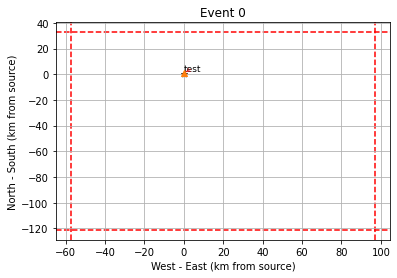

In [14]:
## Save all mechanisms to current folder
mod_mechanisms.save_mt(mechanisms_data, name_sample.replace('XXX', 'tocopy'))
## Loop over each mechanism to generate the atmospheric wavefield
for imecha, mechanism_ in mechanisms_data.iterrows():

    options_out['global_folder'] = name_sample.replace('XXX', str(imecha+1))
    os.system('cp -R ' + name_sample.replace('XXX', 'tocopy')[:-1] + ' ' + options_out['global_folder'])
    Green_RW.set_global_folder(options_out['global_folder'])

    mechanism = {}
    for key in keys_mechanism:
            mechanism[key] = mechanism_[key]

    ## Station distribution
    mod_mechanisms.display_map_stations(mechanism_['EVID'], mechanism_['station_tab'], mechanism_['domain'], options_out['global_folder'])
    

In [20]:
## Save all mechanisms to current folder
mod_mechanisms.save_mt(mechanisms_data, name_sample.replace('XXX', 'tocopy'))
## Loop over each mechanism to generate the atmospheric wavefield
for imecha, mechanism_ in mechanisms_data.iterrows():

    options_out['global_folder'] = name_sample.replace('XXX', str(imecha+1))
    os.system('cp -R ' + name_sample.replace('XXX', 'tocopy')[:-1] + ' ' + options_out['global_folder'])
    Green_RW.set_global_folder(options_out['global_folder'])

    mechanism = {}
    for key in keys_mechanism:
            mechanism[key] = mechanism_[key]

    ## Station distribution
    mod_mechanisms.display_map_stations(mechanism_['EVID'], mechanism_['station_tab'], mechanism_['domain'], options_out['global_folder'])
    
    ## Generate atmospheric model
    station = mechanism_['station_tab']
    domain  = mechanism_['domain']
    param_atmos = velocity_models.generate_default_atmos()

    ## Solve dispersion equations
    RW_atmos.compute_analytical_acoustic(Green_RW, mechanism, param_atmos, station, domain, options_out)

Building time series: [                                        -] Done
save waveform to: ./RIDGECREST_1/waveform_HHZ_test_0.1_1.0_0.0.csv
save waveform to: ./RIDGECREST_1/RW_waveform_z0_HHZ_test_0.1_1.0_0.0.csv


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (5.0) of bandpass is at or above Nyquist (5.0). Applying a high-pass instead.
  warnings.warn(msg)


Finished generating figures in folder: ./RIDGECREST_1/
